<a href="https://colab.research.google.com/github/AndreySamoylenko15/API_Wizards/blob/main/GoIT_HW_11_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [3]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    self.layer1 = DenseLayer(num_features, n_hidden_1, name="layer1")
    # Другий шар, який складається з 256 нейронів
    self.layer2 = DenseLayer(n_hidden_1, n_hidden_2, name="layer2")
    # Вихідний шар
    self.output_layer = DenseLayer(n_hidden_2, num_classes, name="output_layer")

  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax
    x1 = self.layer1(x, activation=0)  # сигмоїдна активація
    x2 = self.layer2(x1, activation=0)  # сигмоїдна активація
    x3 = self.output_layer(x2, activation=1)  # softmax активація

    return x3

In [5]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    acc = tf.metrics.Accuracy()
    acc.update_state(y_true, tf.argmax(y_pred, axis=1))
    return acc.result()
    # # Передбачені класи
    # predicted_classes = tf.argmax(y_pred, axis=1)
    # # Перевірка точності
    # return tf.reduce_mean(tf.cast(tf.equal(predicted_classes, y_true), tf.float32))

In [6]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Отримаємо список оптимізованих параметрів
    trainable_variables = neural_net.trainable_variables

    # Обчислимо за ними значення градієнта
    gradients = g.gradient(loss, trainable_variables)

    # Модифікуємо параметри
    optimizer.apply_gradients(zip(gradients, trainable_variables))
    return loss

In [7]:
# Тренування мережі
loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    loss = train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        current_accuracy = accuracy(pred, batch_y).numpy()
        current_loss = loss.numpy()
        loss_history.append(current_loss)
        accuracy_history.append(current_accuracy)
        print(f"Step {step}, Loss: {current_loss:.4f}, Accuracy: {current_accuracy:.4f}")
print("Optimization Finished!")
test_pred = neural_net(x_test)
test_accuracy = accuracy(test_pred, y_test)
print(f"Test Accuracy: {test_accuracy.numpy():.4f}")

Step 100, Loss: 735.1376, Accuracy: 0.6758
Step 200, Loss: 622.8285, Accuracy: 0.6875
Step 300, Loss: 478.5024, Accuracy: 0.7070
Step 400, Loss: 209.2397, Accuracy: 0.7656
Step 500, Loss: 168.1965, Accuracy: 0.8320
Step 600, Loss: 162.6230, Accuracy: 0.8516
Step 700, Loss: 113.9036, Accuracy: 0.8828
Step 800, Loss: 120.4924, Accuracy: 0.9023
Step 900, Loss: 107.2021, Accuracy: 0.8711
Step 1000, Loss: 79.8920, Accuracy: 0.9180
Step 1100, Loss: 137.4247, Accuracy: 0.8789
Step 1200, Loss: 129.8818, Accuracy: 0.8711
Step 1300, Loss: 88.0599, Accuracy: 0.9023
Step 1400, Loss: 85.6396, Accuracy: 0.9141
Step 1500, Loss: 107.8529, Accuracy: 0.8789
Step 1600, Loss: 131.2872, Accuracy: 0.8828
Step 1700, Loss: 90.8607, Accuracy: 0.8984
Step 1800, Loss: 94.9217, Accuracy: 0.9102
Step 1900, Loss: 76.2055, Accuracy: 0.9180
Step 2000, Loss: 76.3201, Accuracy: 0.9062
Step 2100, Loss: 61.7457, Accuracy: 0.9375
Step 2200, Loss: 58.7216, Accuracy: 0.9375
Step 2300, Loss: 77.9427, Accuracy: 0.9102
Step 24

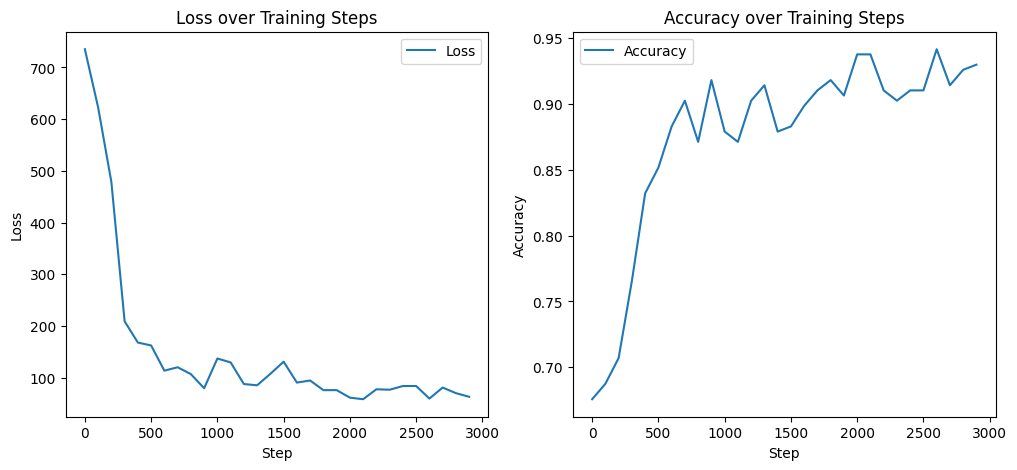

In [8]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Виведіть графік функції втрат
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, training_steps + 1, display_step), loss_history, label='Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Loss over Training Steps')
plt.legend()

# Виведіть графік точності
plt.subplot(1, 2, 2)
plt.plot(range(1, training_steps + 1, display_step), accuracy_history, label='Accuracy')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.title('Accuracy over Training Steps')
plt.legend()

plt.show()



In [9]:
# Обчисліть точність навченої нейромережі

train_pred = neural_net(x_train)
train_accuracy = accuracy(train_pred, y_train)
print(f"Train Accuracy: {train_accuracy.numpy():.4f}")

# Тестування моделі на тестових даних

test_pred = neural_net(x_test)
test_accuracy = accuracy(test_pred, y_test)
print(f"Test Accuracy: {test_accuracy.numpy():.4f}")

Train Accuracy: 0.9219
Test Accuracy: 0.9044


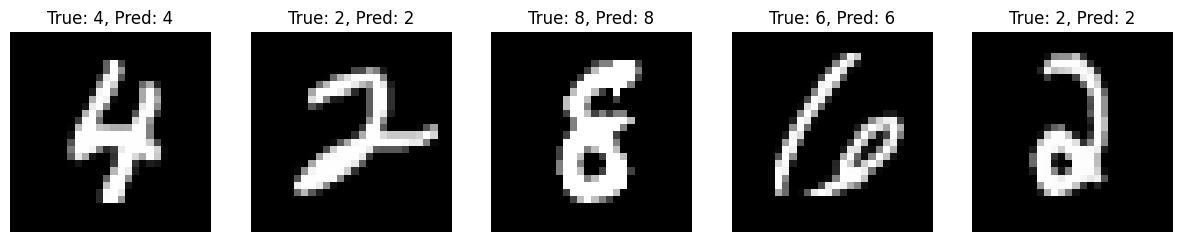

In [10]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

# Протестуйте навчену нейромережу на 10 зображеннях
def test_random_images():
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    random_idx = random.sample(range(x_test.shape[0]), 5)
    for i, ax in enumerate(axes):
        idx = random_idx[i]
        img = x_test[idx].reshape(28, 28)
        true_label = y_test[idx]
        prediction = neural_net(np.expand_dims(x_test[idx], axis=0))
        predicted_label = np.argmax(prediction)

        ax.imshow(img, cmap='gray')
        ax.set_title(f"True: {true_label}, Pred: {predicted_label}")
        ax.axis('off')
    plt.show()

# Виклик функції для тестування на випадкових зображеннях
test_random_images()



In [11]:
# Обчислення втрат на тестових даних
def calculate_test_loss(neural_net, x_test, y_test):
    test_pred = neural_net(x_test)
    test_loss = cross_entropy(test_pred, y_test)
    return test_loss

# Обчислення та виведення втрат на тестових даних
test_loss = calculate_test_loss(neural_net, x_test, y_test)
print(f"Test Loss: {test_loss.numpy():.4f}")

Test Loss: 3256.3372


In [12]:
from sklearn.metrics import classification_report

# Виконання передбачень для тестової вибірки
test_pred = neural_net(x_test)
predicted_classes = tf.argmax(test_pred, axis=1).numpy()

# Виведення метрик якості для кожного класу
report = classification_report(y_test, predicted_classes, target_names=[str(i) for i in range(num_classes)])
print(report)

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       980
           1       0.97      0.97      0.97      1135
           2       0.91      0.88      0.89      1032
           3       0.86      0.89      0.87      1010
           4       0.89      0.92      0.91       982
           5       0.88      0.84      0.86       892
           6       0.94      0.92      0.93       958
           7       0.91      0.91      0.91      1028
           8       0.86      0.87      0.86       974
           9       0.88      0.87      0.88      1009

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



Загальні висновки:
Модель досягла високої загальної точності 90% на тестовому наборі даних. Це свідчить про те, що модель добре вміє класифікувати зображення цифр із набору даних MNIST
Зміни в архітектурі моделі, зокрема використання функцій активації ReLU для прихованих шарів і softmax для вихідного шару, значно покращили результати.
Загальна точність та інші метрики якості демонструють, що модель успішно навчається та ефективно класифікує зображення з набору даних MNIST. Ці результати показують, що модель добре справляється із завданням, але є ще можливості для подальшого вдосконалення та оптимізації.